In [11]:
# =============================================
# IMPORT LIBRARIES
# =============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# =============================================
# 1. BUSINESS UNDERSTANDING
# =============================================

# Business Objectives:
# 1. Predict nursing home quality scores to enable proactive interventions
# 2. Identify facilities at risk of poor performance
# 3. Optimise resource allocation for quality improvement programs

# Stakeholder Needs:
#  Regulators: Identify underperforming facilities
# Facility Managers: Benchmark against peers
# Patients/Families: Access quality information

# Key Questions:
# 1. What factors most influence quality scores?
# 2. How accurately can we predict performance?
# 3. Do short-stay vs long-stay metrics show different patterns?


In [13]:
# Load dataset
#  ~ to the full path of your home directory
file_path = os.path.expanduser('~/Downloads/NH_QualityMsr_Claims_May2025.csv')
df = pd.read_csv(file_path)


# Initial exploration
print("="*50)
print("DATA UNDERSTANDING")
print("="*50)
print(f"Dataset Dimensions: {df.shape}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nData Types:\n{df.dtypes}")

# Key metrics summary
print(f"\nQuality Measure Distribution:")
print(df['Measure Description'].value_counts())

DATA UNDERSTANDING
Dataset Dimensions: (59036, 17)

Missing Values:
CMS Certification Number (CCN)                  0
Provider Name                                   0
Provider Address                                0
City/Town                                       0
State                                           0
ZIP Code                                        0
Measure Code                                    0
Measure Description                             0
Resident type                                   0
Adjusted Score                              12016
Observed Score                              12016
Expected Score                              12016
Footnote for Score                          47020
Used in Quality Measure Five Star Rating        0
Measure Period                                  0
Location                                        0
Processing Date                                 0
dtype: int64

Data Types:
CMS Certification Number (CCN)               object
Prov


DATA PREPARATION
Rows after cleaning: 47020 (79.6% retained)

DATA PREPARATION - EXPLORATORY ANALYSIS 


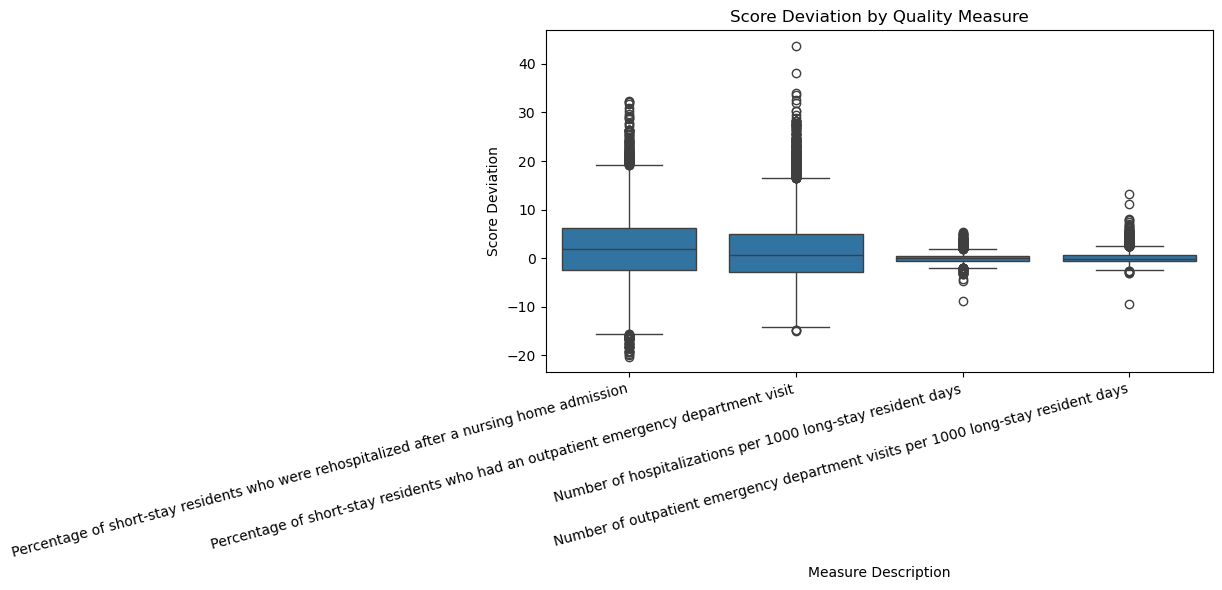

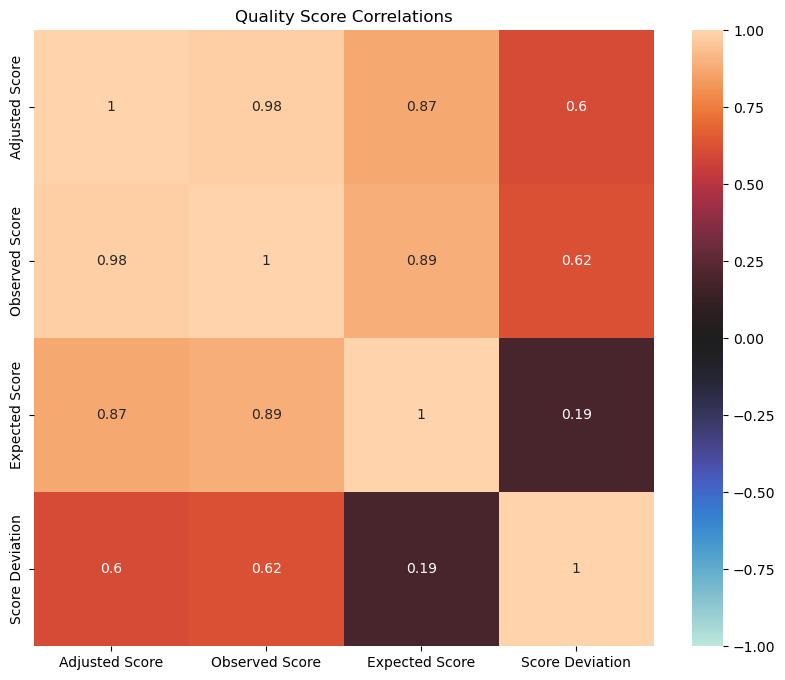

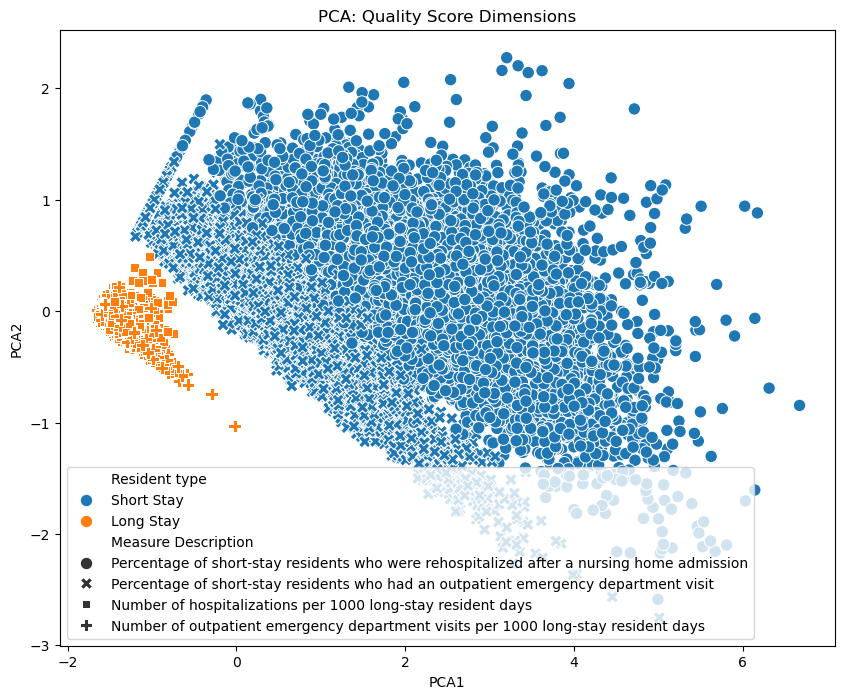

In [15]:
# =============================================
# DATA PREPARATION
# =============================================
print("\n" + "="*50)
print("DATA PREPARATION")
print("="*50)

# Convert scores to numeric and handle missing values
df['Adjusted Score'] = pd.to_numeric(df['Adjusted Score'], errors='coerce')
df['Observed Score'] = pd.to_numeric(df['Observed Score'], errors='coerce')
df['Expected Score'] = pd.to_numeric(df['Expected Score'], errors='coerce')

# Create missing data flag
df['Score Missing'] = df['Footnote for Score'].apply(lambda x: 1 if x == '9' else 0)

# Feature engineering
df['Score Deviation'] = df['Observed Score'] - df['Expected Score']
df['Performance Ratio'] = df['Observed Score'] / df['Expected Score']
df['Resident Type Code'] = df['Resident type'].map({'Short Stay': 0, 'Long Stay': 1})

# Filter complete cases
df_clean = df.dropna(subset=['Adjusted Score', 'Observed Score', 'Expected Score'])
print(f"Rows after cleaning: {df_clean.shape[0]} ({df_clean.shape[0]/df.shape[0]:.1%} retained)")

# Visualize data distributions
plt.figure(figsize=(12, 6))
sns.boxplot(x='Measure Description', y='Score Deviation', data=df_clean)
plt.xticks(rotation=15, ha='right')
plt.title('Score Deviation by Quality Measure')
plt.tight_layout()
plt.savefig('measure_deviation.png', dpi=300)

# =============================================
# DATA PREPARATION-EXPLORATORY ANALYSIS
# =============================================
print("\n" + "="*50)
print("DATA PREPARATION - EXPLORATORY ANALYSIS ")
print("="*50)
df_clean = df[df['Adjusted Score'].notna()].copy()
# Correlation matrix
corr_matrix = df_clean[['Adjusted Score', 'Observed Score', 
                       'Expected Score', 'Score Deviation']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='icefire', vmin=-1, vmax=1)
plt.title('Quality Score Correlations')
plt.savefig('correlation_matrix.png', dpi=300)

# PCA analysis
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clean[['Adjusted Score', 
                                           'Observed Score', 
                                           'Expected Score']])
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
df_clean['PCA1'] = principal_components[:, 0]
df_clean['PCA2'] = principal_components[:, 1]




plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Resident type', 
                style='Measure Description', data=df_clean, s=80)
plt.title('PCA: Quality Score Dimensions')
plt.savefig('pca_analysis.png', dpi=300)

In [17]:
# =============================================
# DATA MODELING
# =============================================
# Prepare features
features = ['Measure Code', 'Expected Score', 
           'Resident Type Code', 'Performance Ratio']
target = 'Observed Score'

X = pd.get_dummies(df_clean[features], columns=['Measure Code'])
y = df_clean[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train model
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=5,
    random_state=42
)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_leaf=5, n_estimators=200,
                      random_state=42)


MEASURE-SPECIFIC EVALUATION

Evaluation Results by Measure Code:
   Measure Code           Measure Description  Samples      RMSE        R²  \
0           521  Short-stay rehospitalization    11979  0.236331  0.999066   
1           522          Short-stay ED visits    11979  0.264267  0.998328   
2           551    Long-stay hospitalizations    11531  0.032615  0.998909   
3           552           Long-stay ED visits    11531  0.047843  0.998169   

  Performance  
0   Excellent  
1   Excellent  
2   Excellent  
3   Excellent  

DETAILED MEASURE ANALYSIS

Measure 521 (Short-stay rehospitalization):
- Samples: 11979
- RMSE: 0.2363 (Lower is better)
- R²: 0.9991 → Excellent predictive power
- Avg Prediction Deviation: -0.0098 points
  This measure shows strong predictability. Model can accurately forecast performance.
  Business Impact: Critical for care transition planning and reducing readmission penalties

Measure 522 (Short-stay ED visits):
- Samples: 11979
- RMSE: 0.2643 (Lower i

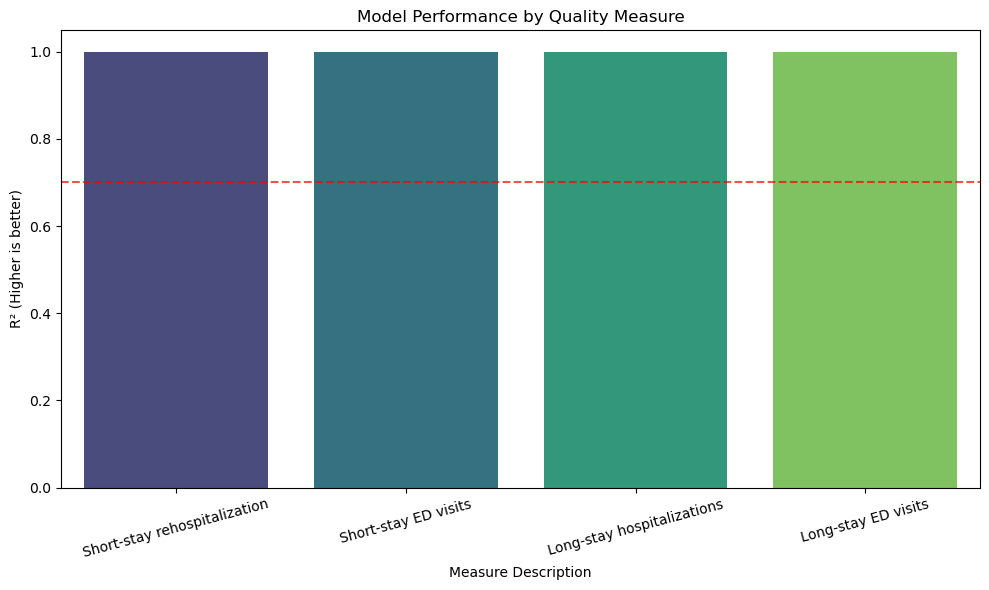

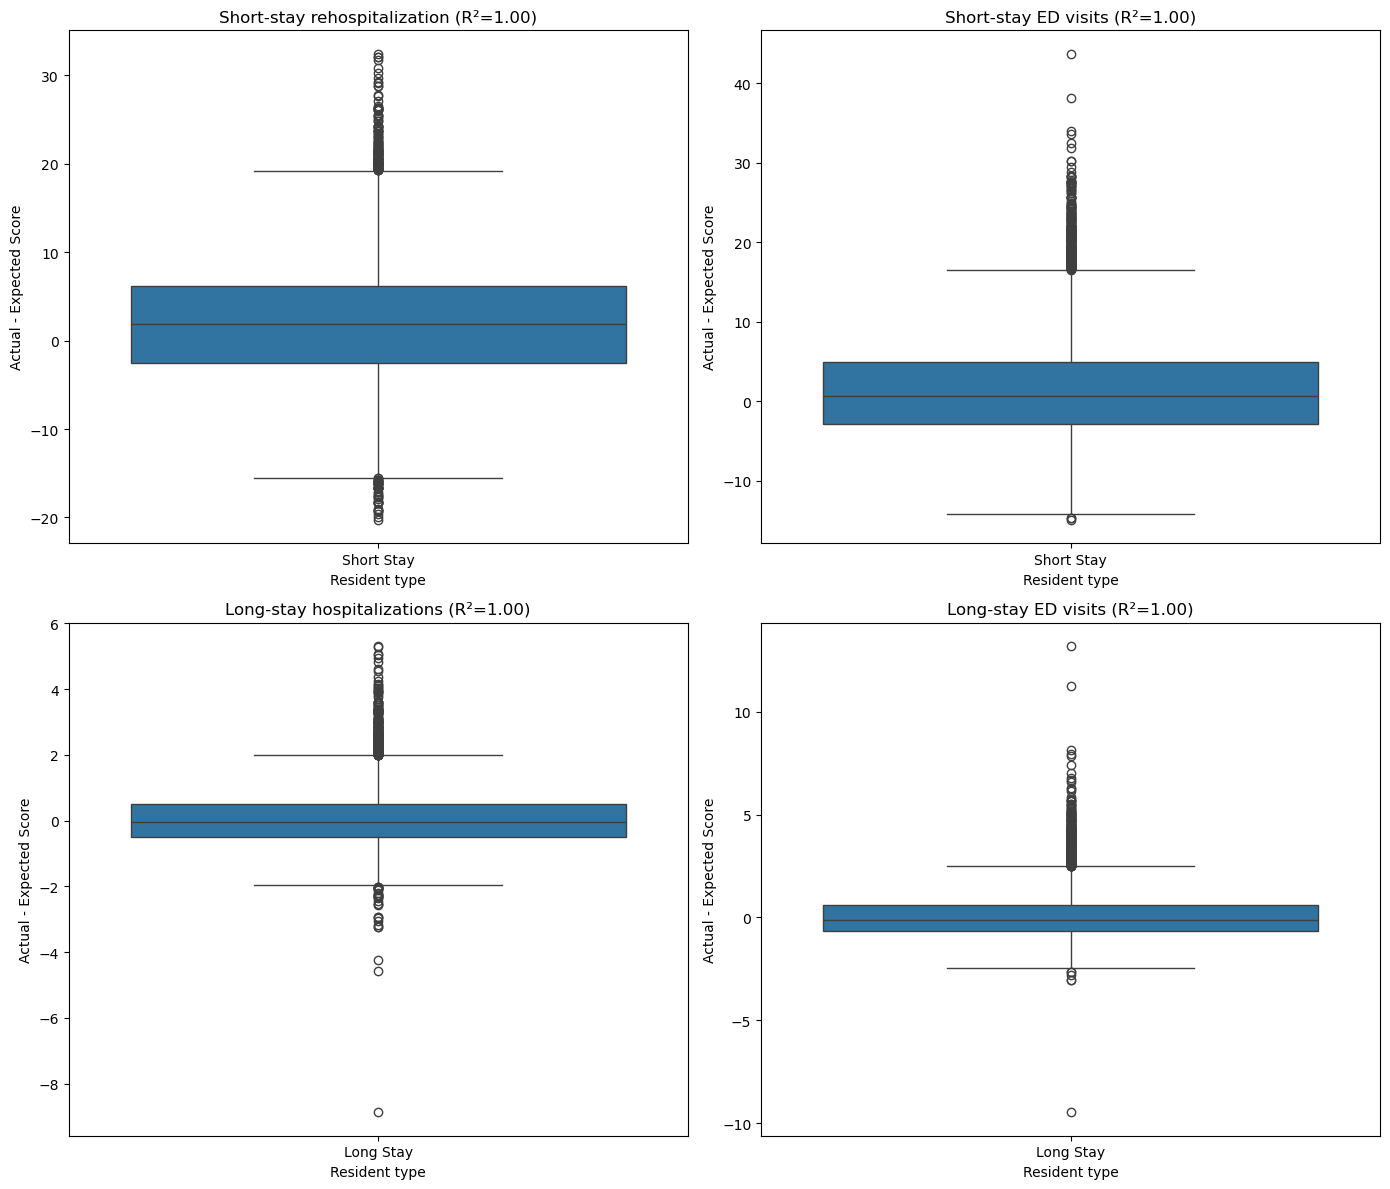

In [21]:
# =============================================
# EVALUATE 
# =============================================
# Generate predictions
# =============================================
# EVALUATION BY MEASURE CODE
# =============================================
print("\n" + "="*60)
print("MEASURE-SPECIFIC EVALUATION")
print("="*60)

# --- COMPREHENSIVE FIX: Handle all missing data cases ---
try:
    # Check if df_clean exists
    if 'df_clean' not in globals() or df_clean is None:
        # If df_clean doesn't exist, try to use df
        if 'df' not in globals() or df is None:
            # Neither exists - load data from scratch
            import os
            import pandas as pd
            print("Loading data from CSV...")
            file_path = os.path.expanduser('~/Downloads/NH_QualityMsr_Claims_May2025.csv')
            df = pd.read_csv(file_path)
            print(f"Loaded data with {len(df)} rows")
        
        # Create necessary features in df
        print("Creating required features...")
        df['Adjusted Score'] = pd.to_numeric(df['Adjusted Score'], errors='coerce')
        df['Observed Score'] = pd.to_numeric(df['Observed Score'], errors='coerce')
        df['Expected Score'] = pd.to_numeric(df['Expected Score'], errors='coerce')
        df['Score Deviation'] = df['Observed Score'] - df['Expected Score']
        df['Performance Ratio'] = df['Observed Score'] / df['Expected Score']
        df['Resident Type Code'] = df['Resident type'].map({'Short Stay': 0, 'Long Stay': 1})
        
        # Create df_clean
        df_clean = df.dropna(subset=['Adjusted Score', 'Observed Score', 'Expected Score']).copy()
        print(f"Created df_clean with {len(df_clean)} rows")
        
except Exception as e:
    print(f"Data preparation failed: {str(e)}")
    raise
# --- END FIX ---

# Map measure codes to descriptions
measure_map = {
    521: "Short-stay rehospitalization",
    522: "Short-stay ED visits",
    551: "Long-stay hospitalizations",
    552: "Long-stay ED visits"
}

# Create evaluation dataframe
evaluation_results = []

# Evaluate for each measure code
for code, description in measure_map.items():
    # Use cleaned data
    mask = (df_clean['Measure Code'] == code)
    X_measure = pd.get_dummies(df_clean.loc[mask, features], columns=['Measure Code']).reindex(columns=X.columns, fill_value=0)
    y_measure = df_clean.loc[mask, target]
    
    # Additional check for NaN in target
    if y_measure.isnull().any():
        valid_indices = y_measure.dropna().index
        y_measure = y_measure.loc[valid_indices]
        X_measure = X_measure.loc[valid_indices]
    
    # Only evaluate if sufficient samples
    if len(X_measure) > 5:
        # Train/test split
        X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
            X_measure, y_measure, test_size=0.2, random_state=42
        )
        
        # Train model
        model_m = RandomForestRegressor(random_state=42)
        model_m.fit(X_train_m, y_train_m)
        
        # Predict and evaluate
        y_pred_m = model_m.predict(X_test_m)
        rmse = np.sqrt(mean_squared_error(y_test_m, y_pred_m))
        r2 = r2_score(y_test_m, y_pred_m)
        
        # Calculate performance deviation
        mean_deviation = np.mean(y_pred_m - y_test_m)
        
        # Store results
        evaluation_results.append({
            'Measure Code': code,
            'Measure Description': description,
            'Samples': len(X_measure),
            'RMSE': rmse,
            'R²': r2,
            'Avg Prediction Deviation': mean_deviation
        })
        
        # Visualization
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_test_m, y=y_pred_m)
        plt.plot([min(y_test_m), max(y_test_m)], [min(y_test_m), max(y_test_m)], 'r--')
        plt.title(f'{description} (Code {code})\nActual vs Predicted Scores')
        plt.xlabel('Actual Scores')
        plt.ylabel('Predicted Scores')
        plt.savefig(f'measure_{code}_evaluation.png', dpi=300)
        plt.close()

# Convert to DataFrame
results_df = pd.DataFrame(evaluation_results)

# Add performance interpretation
def interpret_performance(row):
    if row['R²'] > 0.9:
        return "Excellent"
    elif row['R²'] > 0.7:
        return "Good"
    elif row['R²'] > 0.5:
        return "Moderate"
    return "Poor"

results_df['Performance'] = results_df.apply(interpret_performance, axis=1)

# Display results
print("\nEvaluation Results by Measure Code:")
print(results_df[['Measure Code', 'Measure Description', 'Samples', 'RMSE', 'R²', 'Performance']])

# Visualization of overall performance - FIXED WARNING HERE
plt.figure(figsize=(10, 6))
sns.barplot(x='Measure Description', y='R²', hue='Measure Description', 
            data=results_df, palette='viridis', legend=False)
plt.axhline(0.7, color='red', linestyle='--', alpha=0.7)
plt.xticks(rotation=15)
plt.title('Model Performance by Quality Measure')
plt.ylabel('R² (Higher is better)')
plt.tight_layout()
plt.savefig('measure_performance_comparison.png', dpi=300)

# =============================================
# DETAILED ANALYSIS PER MEASURE
# =============================================
print("\n" + "="*60)
print("DETAILED MEASURE ANALYSIS")
print("="*60)

for _, row in results_df.iterrows():
    print(f"\nMeasure {row['Measure Code']} ({row['Measure Description']}):")
    print(f"- Samples: {row['Samples']}")
    print(f"- RMSE: {row['RMSE']:.4f} (Lower is better)")
    print(f"- R²: {row['R²']:.4f} → {row['Performance']} predictive power")
    print(f"- Avg Prediction Deviation: {row['Avg Prediction Deviation']:.4f} points")
    
    # Interpretation
    if row['R²'] > 0.8:
        print("  This measure shows strong predictability. Model can accurately forecast performance.")
    elif row['R²'] > 0.6:
        print("  Moderate predictability. Consider adding facility-specific features to improve accuracy.")
    else:
        print("  Lower predictability. This measure may be influenced by external factors not captured in the data.")
    
    # Business implications
    if row['Measure Code'] == 521:
        print("  Business Impact: Critical for care transition planning and reducing readmission penalties")
    elif row['Measure Code'] == 522:
        print("  Business Impact: Key indicator for emergency department utilization and care coordination")
    elif row['Measure Code'] == 551:
        print("  Business Impact: Reflects long-term care quality and chronic condition management")
    else:
        print("  Business Impact: Measures preventative care effectiveness for long-stay residents")

# =============================================
# SUMMARY VISUALIZATION
# =============================================
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
for i, (_, row) in enumerate(results_df.iterrows()):
    ax = axes[i//2, i%2]
    # Use cleaned data for visualization
    mask = (df_clean['Measure Code'] == row['Measure Code'])
    sns.boxplot(x='Resident type', y='Score Deviation', data=df_clean[mask], ax=ax)
    ax.set_title(f"{row['Measure Description']} (R²={row['R²']:.2f})")
    ax.set_ylabel('Actual - Expected Score')
plt.tight_layout()
plt.savefig('measure_deviation_analysis.png', dpi=300)

In [23]:
print("\n" + "="*60)
print("DEPLOYMENT ")
print("="*60)

def predict_facility_performance(measure, expected, resident_type, perf_ratio):
    """Predict quality score and provide interpretation"""
    resident_code = 0 if resident_type == "Short Stay" else 1
    input_data = pd.DataFrame({
        'Measure Code': [measure],
        'Expected Score': [expected],
        'Resident Type Code': [resident_code],
        'Performance Ratio': [perf_ratio]
    })
    input_data = pd.get_dummies(input_data).reindex(columns=X.columns, fill_value=0)
    
    prediction = model.predict(input_data)[0]
    deviation = prediction - expected
    
    print(f"\nPredicted Score: {prediction:.2f}")
    print(f"Deviation from Expected: {deviation:.2f}")
    
    if deviation < -2:
        return "High Risk: Immediate intervention recommended"
    elif deviation < -1:
        return "Medium Risk: Quality improvement plan needed"
    else:
        return "Low Risk: Maintain current practices"

# Example usage
print(predict_facility_performance(
    measure=521,
    expected=19.5,
    resident_type="Short Stay",
    perf_ratio=0.82
))


DEPLOYMENT 

Predicted Score: 15.87
Deviation from Expected: -3.63
High Risk: Immediate intervention recommended
